In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import pickle
from torchvision import transforms

import sys
sys.path.append("../ProtoLearning/")

import data as data
from models.icsn import iCSN

In [2]:
def load_pretrained(model, ckpt):
    model.load_state_dict(ckpt['model'])
    model.proto_dict = ckpt['model_misc']['prototypes']
    model.softmax_temp = ckpt['model_misc']['softmax_temp']
    return model
 
    
def plot_test_examples(log_samples, model, config):
    model.eval()
    # apply encoding and decoding over a small subset of the training set
    imgs, labels = log_samples
    imgs = imgs.to(config['device'])
    labels = labels.to(config['device']).float()

    examples_to_show = len(imgs)

    preds, imgs_proto_recon = model.forward_single(imgs)

    # print(f"\nTest Preds: \n{np.round(preds.detach().cpu().numpy(), 2)} \n")

    recons = imgs_proto_recon.detach().cpu()
    imgs = imgs.detach().cpu()
    preds = preds.detach().cpu()

    # compare original images to their reconstructions
    n_rows = 4
    f1, a = plt.subplots(n_rows, examples_to_show, figsize=(examples_to_show, n_rows))

    # set axis off for all
    [axi.set_axis_off() for axi in a.ravel()]

    a[0][0].text(0, -2, s='input', fontsize=10)
    a[1][0].text(0,-2, s='recon proto', fontsize=10)
    a[2][0].text(0,-2, s='GT categories', fontsize=10)
    a[3][0].text(0,-2, s='Pred categories', fontsize=10)

    for i in range(examples_to_show):
        a[0][i].imshow(imgs[i].permute(1, 2, 0).squeeze(),
                       cmap='gray',
                       interpolation='none')

        # convert to RGB numpy array
        recons_np = recons[i].permute(1, 2, 0).squeeze().numpy()
        # convert -1 1 range to 0 255 range for plotting
        recons_np = ((recons_np - recons_np.min())
                          * (1 / (recons_np.max() - recons_np.min()) * 255)).astype('uint8')
        a[1][i].imshow(recons_np,
                       cmap='gray',
                       interpolation='none')

        a[2][i].imshow(labels[i].unsqueeze(dim=0).detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
        a[3][i].imshow(preds[i].unsqueeze(dim=0).detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)

    # plot symbol/prediction arrays
    f2, a = plt.subplots(1, config['n_groups'])
    # set axis off for all
    [axi.set_axis_off() for axi in a.ravel()]
    for group_id in range(config['n_groups']):
        a[group_id].text(0, -2, s=f"category {group_id+1}", fontsize=10)
        a[group_id].imshow(
            preds[:, model.attr_positions[group_id]:model.attr_positions[group_id+1]].detach().cpu().numpy(),
            cmap='gray', vmin=0, vmax=1
        )

    plt.show()
    return f1, f2

def plot_single_test_img(model, imgs, idx):
    model.eval()
    preds, recons = model.forward_single(imgs)

    recons = recons.permute(0, 2, 3, 1).detach().cpu()
    imgs = imgs.permute(0, 2, 3, 1).detach().cpu()
    preds = preds.unsqueeze(dim=0).detach().cpu()

    # convert to RGB numpy array
    recons_np = recons[idx].squeeze().numpy()
    # convert -1 1 range to 0 255 range for plotting
    recons_np = ((recons_np - recons_np.min())
              * (1 / (recons_np.max() - recons_np.min()) * 255)).astype('uint8')
    fig, ax = plt.subplots(nrows=3, ncols=1)
    ax[0].imshow(imgs[idx])
    ax[0].axis('off')
    ax[0].set_title("Input Img");
    ax[1].imshow(recons_np)
    ax[1].axis('off')
    ax[1].set_title("Recon (Prototype) Img");
    ax[2].imshow(preds[0, idx].unsqueeze(dim=0))
    ax[2].axes.yaxis.set_visible(False)
    ax[2].set_title("Pred. Attributes");
    ax[2].set_xlabel("Attributes");
    plt.show()
    return fig


In [24]:
# device = 'cpu'
seed = 0
ckpt_fp = f"runs/icsn-rr-{seed}-ecr/states/00199.pth"
save_fp = f"runs/icsn-rr-{seed}-ecr-newshape/"
ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
config = ckpt['config']
config['device'] = 'cpu'
config['data_dir'] = '../Data/ECR/'

In [25]:
model = iCSN(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], enc_size=config['enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

model = model.to(config['device'])
model = load_pretrained(model, ckpt)
model.eval();

Loading ../Data/ToyData//train_simpleshapes_colorvar_shape_size_mult_factor_pairs.npy


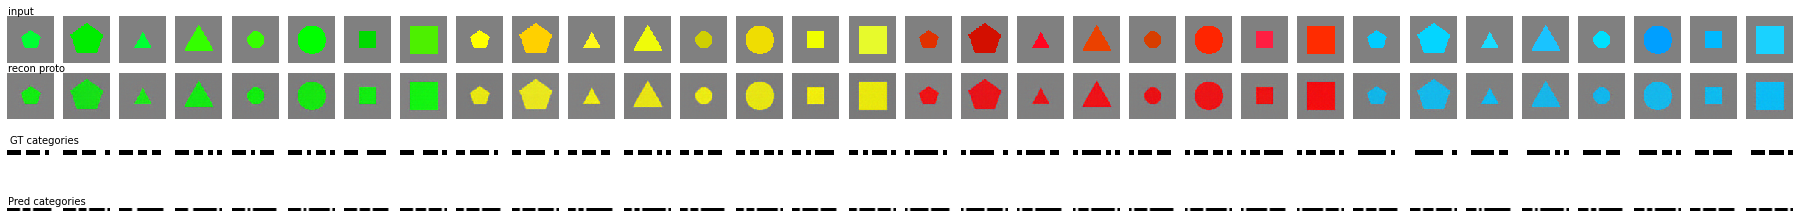

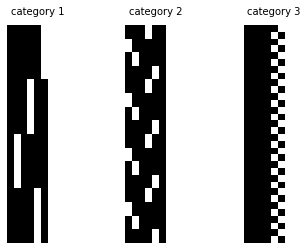

In [26]:
# get test data
_data_loader = data.get_dataloader(config)
test_set = data.get_test_set(_data_loader, config)

# get test set samples
imgs, labels = test_set

# sanity check
fig1, fig2 = plot_test_examples(test_set, model, config)
# fig1.savefig(save_fp + 'prior_test_set.jpg')
# fig2.savefig(save_fp + 'prior_test_set_symbols.jpg')

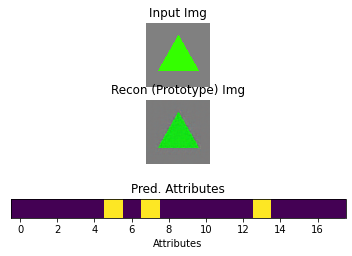

In [10]:
# visualize test set individually
test_imgs, test_labels = test_set
_ = plot_single_test_img(model, test_imgs, idx=3)

# Present new shape image

In [8]:
# get new shape data
new_shape_np = np.load('../Data/ECR/train_ecr_newshape.npy')
new_shape_np = (new_shape_np - new_shape_np.min()) / (new_shape_np.max() - new_shape_np.min())
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])
new_shape_imgs = torch.empty(new_shape_np.shape)
new_shape_imgs = new_shape_imgs.permute(0, 3, 1, 2)
for i in range(new_shape_imgs.shape[0]):
    new_shape_imgs[i] = transform(np.uint8(new_shape_np[i]*255)).float()

labels_fp = "../Data/ECR/train_ecr_newshape_labels.pkl"
with open(labels_fp, 'rb') as f:
    labels_dict = pickle.load(f)
    new_shape_labels = labels_dict['labels_one_hot']
    new_shape_labels_as_id = labels_dict['labels']

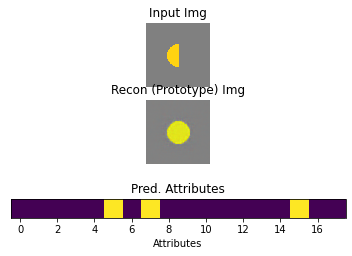

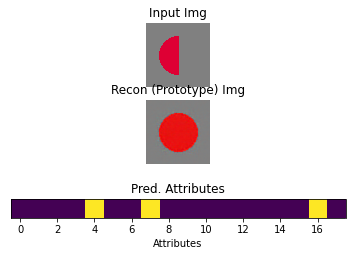

In [23]:
# # Visualize individual new shape image
# fig1 = plot_single_test_img(model, new_shape_imgs, idx=4)
# fig2 = plot_single_test_img(model, new_shape_imgs, idx=0)

# # fig1.savefig(save_fp + 'prior_new_shape1.jpg')
# # fig2.savefig(save_fp + 'prior_new_shape2.jpg')

# Train for new shape concept

### Identify the concept slot ids that are already bound and set empty one for new shape

In [6]:
def get_new_attr_id(seed):
    if seed == 0:
        # category id for which to add a new attribute
        CAT_ID = 1
        # attribute ids which are already binded to within that category
        BINDED_ATTR_IDS = [1, 3, 4, 5]
        # attribute id for new attribute
        NEW_SHAPE_ATTR_ID = 0
    elif seed == 1:
        # category id for which to add a new attribute
        CAT_ID = 1
        # attribute ids which are already binded to within that category
        BINDED_ATTR_IDS = [0, 1, 3, 4]
        # attribute id for new attribute
        NEW_SHAPE_ATTR_ID = 5
    elif seed == 3:
        # category id for which to add a new attribute
        CAT_ID = 1
        # attribute ids which are already binded to within that category
        BINDED_ATTR_IDS = [0, 1, 2, 4]
        # attribute id for new attribute
        NEW_SHAPE_ATTR_ID = 3
    elif seed == 13:
        # category id for which to add a new attribute
        CAT_ID = 1
        # attribute ids which are already binded to within that category
        BINDED_ATTR_IDS = [1, 3, 4, 5]
        # attribute id for new attribute
        NEW_SHAPE_ATTR_ID = 0
    elif seed == 21:
        # category id for which to add a new attribute
        CAT_ID = 1
        # attribute ids which are already binded to within that category
        BINDED_ATTR_IDS = [1, 2, 4, 5]
        # attribute id for new attribute
        NEW_SHAPE_ATTR_ID = 0
    return CAT_ID, BINDED_ATTR_IDS, NEW_SHAPE_ATTR_IDS

In [28]:
def get_novel_concept_data(model, config, CAT_ID, BINDED_ATTR_IDS, NEW_SHAPE_ATTR_IDS):

    # mix the new shape data with some additional old trainig data to prevent forgetting
    # get train data
    config['batch_size'] = 512
    config['img_shape'] = (3, 64, 64)
    train_dataset = data.SimpleShapesPairswithTest(config['data_dir'], 
                                                   attrs='colorvar_shape_size_mult_factor', 
                                                   mode='train', 
                                                   single=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

    # get a single batch from the previous training data
    batch = next(iter(train_loader))
    train_imgs, train_labels_one_hot, train_labels_id = batch
    train_imgs = train_imgs.to(config['device'])

    # let model predict the labels for all previous training samples
    preds, recons = model.forward_single(train_imgs)
    gt_train_labels_one_hot = torch.clone(preds)
    gt_train_labels_one_hot[gt_train_labels_one_hot > 0.5] = 1.
    gt_train_labels_one_hot[gt_train_labels_one_hot <= 0.5] = 0.

    # let model predict the labels for the new train imgs and replace the labels for the relevant 
    # new shape category with a desired label
    preds, recons = model.forward_single(new_shape_imgs)

    # GT one hot encoding stating which attribute the new shape should be predicted as
    gt_one_hot_new_shape = torch.zeros(config['prototype_vectors'][CAT_ID])
    gt_one_hot_new_shape[NEW_SHAPE_ATTR_ID] = 1.
    gt_new_shape_labels_one_hot = torch.clone(preds)
    gt_new_shape_labels_one_hot[gt_new_shape_labels_one_hot > 0.5] = 1.
    gt_new_shape_labels_one_hot[gt_new_shape_labels_one_hot <= 0.5] = 0.
    gt_new_shape_labels_one_hot[:, model.attr_positions[CAT_ID]:model.attr_positions[CAT_ID+1]] = gt_one_hot_new_shape

    new_train_imgs = torch.cat([train_imgs, new_shape_imgs], dim=0)
    new_train_labels_as_id = torch.cat([gt_train_labels_one_hot.detach(), gt_new_shape_labels_one_hot.detach()], dim=0)

    new_train_dataset = torch.utils.data.TensorDataset(new_train_imgs, new_train_labels_as_id)
    new_train_dataloader = torch.utils.data.DataLoader(new_train_dataset, batch_size=128,
                                                      shuffle=True)
    return new_train_dataloader


for seed in [0, 1, 3, 13]:
    ckpt_fp = f"runs/icsn-rr-{seed}-ecr/states/00199.pth"
    save_fp = f"runs/icsn-rr-{seed}-ecr-newshape/"
    ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
    config = ckpt['config']
    config['device'] = 'cpu'
    config['data_dir'] = '../Data/ECR/'

    model = iCSN(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                        n_proto_vecs=config['prototype_vectors'], enc_size=config['enc_size'],
                        proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                        extra_mlp_dim=config['extra_mlp_dim'],
                        multiheads=config['multiheads'], train_protos=config['train_protos'],
                        device=config['device'])


    model = model.to(config['device'])
    model = load_pretrained(model, ckpt)
    model.eval();

    # get the new attribute id, based on the seed
    CAT_ID, BINDED_ATTR_IDS, NEW_SHAPE_ATTR_IDS = get_new_attr_id(seed)
    
    # get novel concept data set, with gt labels predicted by the model itself, except for novel concept
    new_train_dataloader = get_novel_concept_data(model, config, CAT_ID, BINDED_ATTR_IDS, NEW_SHAPE_ATTR_IDS)

    config['print_step'] = 20
    config['lambda_recon_proto'] = 0.
    config['lambda_binding_loss'] = 10.
    config['learning_rate'] = 0.00005

    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

    model.train()
    model.softmax_temp = 1.

    # clf_criterion = torch.nn.CrossEntropyLoss()

    # plot_single_test_img(model, test_imgs, idx=3)

    for e in range(0, 600):
        start = time.time()

        loss_dict = dict(
            {'loss': 0, "recon_loss": 0, "binding_loss": 0})

        torch.autograd.set_detect_anomaly(True)

        for i, batch in enumerate(new_train_dataloader):

            imgs, gt_labels_one_hot = batch
            imgs = imgs.to(config['device'])
            gt_labels_one_hot = gt_labels_one_hot.to(config['device'])
            batch_size = imgs.shape[0]

            # step scheduler for soft max temp
            if e >= 200:
                model.softmax_temp = .0001
            elif e >= 150:
                model.softmax_temp = .001
            elif e >= 100:
                model.softmax_temp = .01
            elif e >= 50:
                model.softmax_temp = .1

            # turn reconstruction loss on after certain epochs
            if e >= 300:
                config['lambda_recon_proto'] = 1.

            # [B, N_Protos], [B, 3, W, H]
            preds, recons = model.forward_single(imgs)

            ave_recon_loss = F.mse_loss(recons, imgs)

            ave_binding_loss = F.smooth_l1_loss(preds, gt_labels_one_hot, reduction="mean")


            loss = config['lambda_recon_proto'] * ave_recon_loss + \
                    config['lambda_binding_loss'] * ave_binding_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_dict['recon_loss'] += ave_recon_loss.item() if config['lambda_recon_proto'] > 0. else 0.
            loss_dict['binding_loss'] += ave_binding_loss.item() if config['lambda_binding_loss'] > 0. else 0.
            loss_dict['loss'] += loss.item()

        for key in loss_dict.keys():
            loss_dict[key] /= len(new_train_dataloader)

        if (e + 1) % config['print_step'] == 0 or e == config['epochs'] - 1:
            print(f'epoch {e} - loss {loss.item():2.4f} - time/epoch {(time.time() - start):2.2f}'
              f'- softmax_temp {model.softmax_temp}')
            loss_summary = ''
            for key in loss_dict.keys():
                loss_summary += f'{key} {loss_dict[key]:2.4f} '
            print(loss_summary)

    state = {
        'model': model.cpu().state_dict(),
        'model_misc': {'prototypes': model.cpu().proto_dict,
                       'softmax_temp': model.cpu().softmax_temp},
        'optimizer': optimizer.state_dict(),
        'ep': e,
        'config': config
    }
    torch.save(state, f"{save_fp}states/final.pth")

Loading ../Data/ToyData//train_simpleshapes_colorvar_shape_size_mult_factor_pairs.npy
epoch 19 - loss 0.6932 - time/epoch 2.84- softmax_temp 1.0
loss 0.6933 recon_loss 0.0000 binding_loss 0.0693 
epoch 39 - loss 0.6918 - time/epoch 3.70- softmax_temp 1.0
loss 0.6918 recon_loss 0.0000 binding_loss 0.0692 
epoch 59 - loss 0.6372 - time/epoch 2.69- softmax_temp 0.1
loss 0.6379 recon_loss 0.0000 binding_loss 0.0638 
epoch 79 - loss 0.6029 - time/epoch 3.02- softmax_temp 0.1
loss 0.6033 recon_loss 0.0000 binding_loss 0.0603 
epoch 99 - loss 0.5680 - time/epoch 3.04- softmax_temp 0.1
loss 0.5686 recon_loss 0.0000 binding_loss 0.0569 
epoch 119 - loss 0.0083 - time/epoch 3.03- softmax_temp 0.01
loss 0.0068 recon_loss 0.0000 binding_loss 0.0007 
epoch 139 - loss 0.0022 - time/epoch 3.42- softmax_temp 0.01
loss 0.0031 recon_loss 0.0000 binding_loss 0.0003 
epoch 159 - loss 0.0056 - time/epoch 3.06- softmax_temp 0.001
loss 0.0073 recon_loss 0.0000 binding_loss 0.0007 
epoch 179 - loss 0.0111 - t

epoch 239 - loss 0.0528 - time/epoch 4.31- softmax_temp 0.0001
loss 0.0446 recon_loss 0.0000 binding_loss 0.0045 
epoch 259 - loss 0.0458 - time/epoch 4.06- softmax_temp 0.0001
loss 0.0430 recon_loss 0.0000 binding_loss 0.0043 
epoch 279 - loss 0.0304 - time/epoch 3.48- softmax_temp 0.0001
loss 0.0388 recon_loss 0.0000 binding_loss 0.0039 
epoch 299 - loss 0.0252 - time/epoch 3.48- softmax_temp 0.0001
loss 0.0384 recon_loss 0.0000 binding_loss 0.0038 
epoch 319 - loss 0.0393 - time/epoch 3.86- softmax_temp 0.0001
loss 0.0403 recon_loss 0.0044 binding_loss 0.0036 
epoch 339 - loss 0.0417 - time/epoch 3.83- softmax_temp 0.0001
loss 0.0369 recon_loss 0.0041 binding_loss 0.0033 
epoch 359 - loss 0.0477 - time/epoch 3.71- softmax_temp 0.0001
loss 0.0370 recon_loss 0.0045 binding_loss 0.0032 
epoch 379 - loss 0.0270 - time/epoch 3.26- softmax_temp 0.0001
loss 0.0357 recon_loss 0.0043 binding_loss 0.0031 
epoch 399 - loss 0.0397 - time/epoch 3.80- softmax_temp 0.0001
loss 0.0354 recon_loss 0.

KeyboardInterrupt: 

### Load model trained on new shape

In [21]:
# device = 'cpu'
ckpt_fp = f"runs/icsn-rr-{seed}-ecr/states/00199.pth"
save_fp = f"runs/icsn-rr-{seed}-ecr-newshape/"
ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
config = ckpt['config']
config['device'] = 'cpu'
config['data_dir'] = '../Data/ECR/'
model_prior = iCSN(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], enc_size=config['enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

model_prior = model_prior.to(config['device'])
model_prior = load_pretrained(model_prior, ckpt)
model_prior.eval();


model_post = iCSN(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], enc_size=config['enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

model_post = model_post.to(config['device'])
model_post.eval();

ckpt_fp = f"{save_fp}states/final.pth"
ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
model_post = load_pretrained(model_post, ckpt)
model_post.softmax_temp = .000001

In [35]:
# # model.extra_softmax=True
# model.softmax_temp = .000001
# plot_single_test_img(model, test_imgs, idx=3)

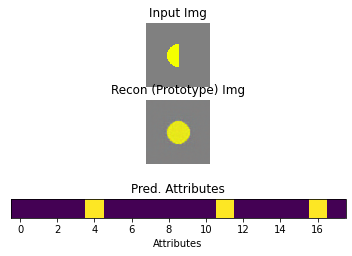

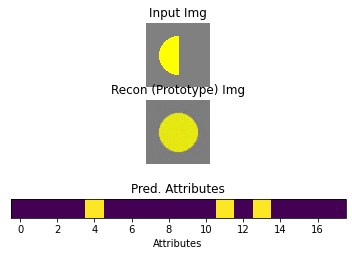

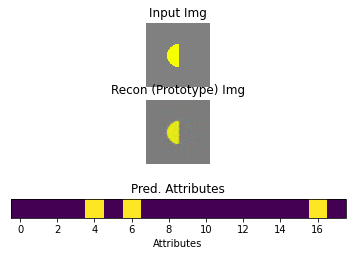

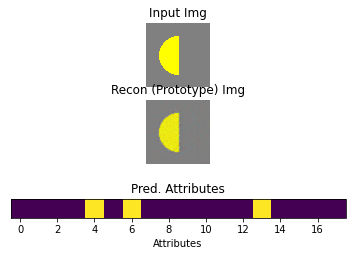

In [22]:
fig1 = plot_single_test_img(model_prior, new_shape_imgs, idx=4)
fig2 = plot_single_test_img(model_prior, new_shape_imgs, idx=2)

fig3 = plot_single_test_img(model_post, new_shape_imgs, idx=4)
fig4 = plot_single_test_img(model_post, new_shape_imgs, idx=2)

# fig3.savefig(save_fp + 'imgs/post_new_shape1.jpg')
# fig4.savefig(save_fp + 'imgs/post_new_shape2.jpg')

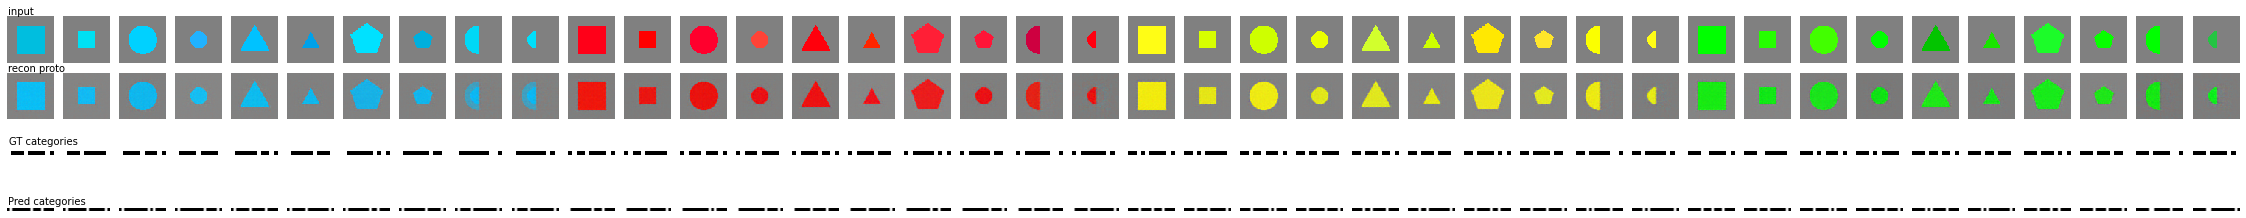

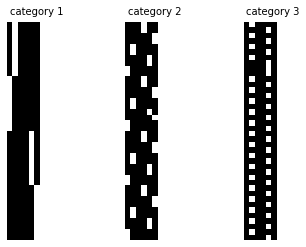

In [23]:
new_test_data_path = f"../Data/ECR/test_ecr_newshape.npy"
new_test_labels_path = f"../Data/ECR/test_ecr_newshape.pkl"

new_test_imgs = np.load(new_test_data_path, allow_pickle=True)
new_test_imgs = (new_test_imgs - new_test_imgs.min()) / (new_test_imgs.max() - new_test_imgs.min())

with open(new_test_labels_path, 'rb') as f:
    labels_dict = pickle.load(f)
    new_test_labels = labels_dict['labels_one_hot'].squeeze(axis=1)
    
new_test_imgs = torch.tensor(np.moveaxis(new_test_imgs.squeeze(axis=1), (0, 1, 2, 3), (0, 2, 3, 1)))
new_test_imgs = new_test_imgs.type('torch.FloatTensor')
new_test_labels = torch.tensor(new_test_labels)    
    
# new_test_dataset = data.SimpleShapesPairswithTest(config['data_dir'], 
#                                                attrs='colorvar_new_shape_size', 
#                                                mode='train', 
#                                                single=True)
# # data.ToyDataPairs(config['data_dir'], "test", attrs='colorvar_new_shape_size', single=True)
# new_test_imgs, new_test_labels = new_test_dataset.get_ordered_test_set()
new_test_imgs = new_test_imgs.to(config['device'])
new_test_set = (new_test_imgs, new_test_labels)
fig1, fig2 = plot_test_examples(new_test_set, model_post, config)
fig1.savefig(save_fp + 'imgs/post_test_set.jpg')
fig2.savefig(save_fp + 'imgs/post_test_set_symbols.jpg')

### Create a dictionary to convert a label list of individual groups to a single id

In [53]:
convert_multilabel_to_label_id = {}
id = 0
for i in range(5):
    for j in range(4):
        for k in range(2):
            convert_multilabel_to_label_id[f'{i}{j}{k}'] = id
            id+=1

### Create a dictionary to convert a single label list of individual groups to a one hot encoding

In [ ]:
convert_label_id_to_multilabel = {}
for i, label in enumerate(convert_multilabel_to_label_id.keys()):
    multi_label_ids = [int(char) for char in label]
    tmp = []
    for attr_id in multi_label_ids:
        one_hot = np.zeros(6)
        one_hot[attr_id] = 1
        tmp.extend(one_hot)
    print(tmp)
    convert_label_id_to_multilabel[i] = np.array(tmp)

### Get training and validation set containing old and new objects for linear probing

In [106]:
# train data set
train_probing_data_path = f"../Data/ECR/train_probing/train_probing_ecr_newshape.npy"
train_probing_labels_path = f"../Data/ECR/train_probing/train_probing_ecr_newshape.pkl"

train_probing_imgs = np.load(train_probing_data_path, allow_pickle=True)
train_probing_imgs = (train_probing_imgs - train_probing_imgs.min()) / (train_probing_imgs.max() - train_probing_imgs.min())

with open(train_probing_labels_path, 'rb') as f:
    labels_dict = pickle.load(f)
    train_probing_labels = labels_dict['labels']
  
train_probing_imgs = torch.tensor(np.moveaxis(train_probing_imgs, (0, 1, 2, 3), (0, 2, 3, 1)))
train_probing_imgs = train_probing_imgs.type('torch.FloatTensor')
train_probing_labels = torch.tensor(train_probing_labels)    

# convert multi label to single label
train_probing_labels = train_probing_labels.int()
single_train_probing_labels = torch.tensor([convert_multilabel_to_label_id[f'{train_probing_labels[i][0].item()}{train_probing_labels[i][1].item()}{train_probing_labels[i][2].item()}'] for i in range(train_probing_labels.shape[0])])

train_probing_dataset = torch.utils.data.TensorDataset(train_probing_imgs, single_train_probing_labels)
train_probing_dataloader = torch.utils.data.DataLoader(train_probing_dataset, batch_size=len(train_probing_dataset),
                                                  shuffle=True)

# val data set
val_data_path = f"../Data/ECR/val_ecr_newshape.npy"
val_labels_path = f"../Data/ECR/val_ecr_newshape_labels.pkl"

val_imgs = np.load(val_data_path, allow_pickle=True)
val_imgs = (val_imgs - val_imgs.min()) / (val_imgs.max() - val_imgs.min())

with open(val_labels_path, 'rb') as f:
    labels_dict = pickle.load(f)
    val_labels = labels_dict['labels']
  
val_imgs = torch.tensor(np.moveaxis(val_imgs, (0, 1, 2, 3), (0, 2, 3, 1)))
val_imgs = val_imgs.type('torch.FloatTensor')
val_labels = torch.tensor(val_labels)    

# convert multi label to single label
val_labels = val_labels.int()
single_val_labels = torch.tensor([convert_multilabel_to_label_id[f'{val_labels[i][0].item()}{val_labels[i][1].item()}{val_labels[i][2].item()}'] for i in range(val_labels.shape[0])])

val_dataset = torch.utils.data.TensorDataset(val_imgs, single_val_labels)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset),
                                                  shuffle=True)

### Compute latent code for train set

In [115]:
batch = next(iter(train_probing_dataloader))
imgs, gt_labels = batch
imgs = imgs.to(config['device'])
train_gt_labels = gt_labels.to(config['device'])
batch_size = imgs.shape[0]

train_preds_prior, _ = model_prior.forward_single(imgs)
train_preds_post, _ = model_post.forward_single(imgs)

### Compute latent code for validation set

In [116]:
batch = next(iter(val_dataloader))
imgs, gt_labels = batch
imgs = imgs.to(config['device'])
val_gt_labels = gt_labels.to(config['device'])
batch_size = imgs.shape[0]

val_preds_prior, _ = model_prior.forward_single(imgs)
val_preds_post, _ = model_post.forward_single(imgs)

### Train decision tree and logistic regression 

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# decision tree
clf_prosa_dt_prior = DecisionTreeClassifier(random_state=21, max_depth=8)
clf_prosa_dt_prior.fit(train_preds_prior.detach().cpu().numpy(), train_gt_labels.numpy())
clf_prosa_dt_post = DecisionTreeClassifier(random_state=21, max_depth=8)
clf_prosa_dt_post.fit(train_preds_post.detach().cpu().numpy(), train_gt_labels.numpy())

# Perform logistic regression
clf_prosa_lr_prior = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
clf_prosa_lr_prior.fit(train_preds_prior.detach().cpu().numpy(), train_gt_labels.numpy())
clf_prosa_lr_post = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
clf_prosa_lr_post.fit(train_preds_post.detach().cpu().numpy(), train_gt_labels.numpy())

# Evaluate using the classifiers
predictions_dt_prior = clf_prosa_dt_prior.predict(val_preds_prior.detach().cpu().numpy())
predictions_lr_prior = clf_prosa_lr_prior.predict(val_preds_prior.detach().cpu().numpy())
predictions_dt_post = clf_prosa_dt_post.predict(val_preds_post.detach().cpu().numpy())
predictions_lr_post = clf_prosa_lr_post.predict(val_preds_post.detach().cpu().numpy())

accuracy_dt_prior = np.mean((val_gt_labels.numpy() == predictions_dt_prior).astype(np.float)) * 100.
accuracy_lr_prior = np.mean((val_gt_labels.numpy() == predictions_lr_prior).astype(np.float)) * 100.
accuracy_dt_post = np.mean((val_gt_labels.numpy() == predictions_dt_post).astype(np.float)) * 100.
accuracy_lr_post = np.mean((val_gt_labels.numpy() == predictions_lr_post).astype(np.float)) * 100.

print(f"Val accuracy DT prior codes = {accuracy_dt_prior:.3f}")
print(f"Val accuracy LR prior codes = {accuracy_lr_prior:.3f}")
print(f"Val accuracy DT post codes = {accuracy_dt_post:.3f}")
print(f"Val accuracy LR post codes = {accuracy_lr_post:.3f}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Val accuracy DT prior codes = 80.950
Val accuracy LR prior codes = 80.200
Val accuracy DT post codes = 100.000
Val accuracy LR post codes = 100.000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
